In [2]:
import pandas as pd

In [16]:
sourcepath = '../sprint_2/data/whiskyinfo.parquet'

In [216]:
df = pd.read_parquet('../sprint_2/data/whisky_tfidf.parquet')
whiskyinfo = pd.read_parquet('../sprint_2/data/whiskyinfo.parquet')
similarities = pd.read_parquet('../sprint_2/data/similarities2.parquet')

## Generate Wordcloud Images

In [3]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from palettable.colorbrewer.sequential import  OrRd_9, YlOrBr_9
import random
import plotly.tools as tls

In [146]:
font_path = "dash_app/OpenSans-CondBold.ttf"
output_path = "dash_app/wordclouds/"
wcsize = 800

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(OrRd_9.colors[random.randint(2,8)])

def generatewordcloud(whiskynum):
    whisky = whiskyinfo.reset_index().iloc[whiskynum]
    itemnumber = whisky.itemnumber 
    words = whisky.nose.tolist() + whisky.taste.tolist() + whisky.finish.tolist()
    words = [word.upper() for word in words]
    
    wc = WordCloud(background_color="white",font_path=font_path, max_font_size=300,
                   width = wcsize, height=wcsize,random_state=42, prefer_horizontal=1)
    wc.generate(' '.join(words))
    wc.recolor(color_func=color_func, random_state=3)
    wc.to_file(output_path+str(itemnumber)+'.png')

    #plt.imshow(wc, interpolation='bilinear')

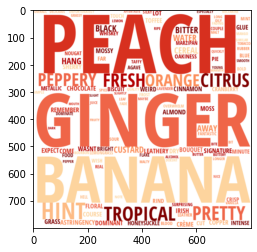

In [145]:
generatewordcloud(0)

In [136]:
for i in range(whiskyinfo.shape[0]):
    try:
        generatewordcloud(i)
    except:
        print(i)

59
108
319


In [139]:
df.iloc[319]

RedditWhiskyIDs      [6789]
reviewIDs           [26722]
rating_mean              77
rating_std              NaN
style              Highland
index_col               319
nose                     []
taste                    []
finish                   []
Name: (ROYAL BRACKLA 12 YEAR OLD HIGHLAND SINGLE MALT SCOTCH WHISKY, 441055), dtype: object

## Review Links

In [15]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib.parse
import urllib.request
import re
import time
from urllib.error import HTTPError
import multiprocessing as mp
import math
import numpy as np

### Multiprocess Functions to Pull Item Links

In [209]:
def productSearch(itemnumber):
    url = 'https://www.lcbo.com/webapp/wcs/stores/servlet/SearchDisplay?sType=SimpleSearch&beginIndex=0&pageSize=12&catalogId=10051&langId=-1&showResultsPage=true&storeId=10203&searchTerm=' + str(itemnumber)
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    values = {'name' : 'Firstname Lastname',
              'location' : 'Toronto',
              'language' : 'Python' }
    headers = { 'User-Agent' : user_agent }
    data = urllib.parse.urlencode(values)
    data = data.encode('ascii')
    req = urllib.request.Request(url, data, headers)
    try:
        with urllib.request.urlopen(req) as response:
           content = response.read()
        html = BeautifulSoup(content, 'html.parser')
        try:
            regex = r'(?<=document\.location\.href \= \")[^\"]*(?=\")'
            link = re.findall(regex, str(html))[0]
            return link
        except:
            # might just show result page so gotta grab the link
            regex = '(?<=a href\=\")https:\/\/www.lcbo.com[^"]*' + str(itemnumber)
            link = re.findall(regex, str(html))[0]
            return link
    except:
        return None

def get_product_links(dataframe):
    global results
    results = pd.DataFrame(columns=['itemnumber','link'])
    
    # split dataframe into even chunks of counties, one chunk per core
    
    chunkcount = mp.cpu_count()
    chunksize = math.ceil(len(dataframe)/chunkcount)

    pool = mp.Pool(chunkcount)
    for g, df in dataframe.groupby(np.arange(len(dataframe)) // chunksize):
        pool.apply_async(mp_product_links,
                         args = (df,),
                         callback=collect_result)
    pool.close()
    pool.join()
    
    return results

# each core runs this function to loop through the chunk and find links
def mp_product_links(df):
    subresult = pd.DataFrame(columns=['itemnumber','link'])
    for item in df.itertuples():
        itemnumber = item.itemnumber
        link = productSearch(itemnumber)
        subresult = subresult.append({'itemnumber':itemnumber,'link':link}, ignore_index=True)

    return subresult

# gather results together
def collect_result(result):
    global results
    results = results.append(result)

Here I append item links using the multiprocess function

In [210]:
allitemnumbers = pd.DataFrame(df.reset_index()['itemnumber']).assign(link = None)

itemlinks = get_product_links(allitemnumbers)
itemlinks.head()

,itemnumber,link
0,479949,https://www.lcbo.com/webapp/wcs/stores/servlet...
1,281824,https://www.lcbo.com/webapp/wcs/stores/servlet...
2,575001,https://www.lcbo.com/webapp/wcs/stores/servlet...
3,455329,https://www.lcbo.com/webapp/wcs/stores/servlet...
4,517904,https://www.lcbo.com/webapp/wcs/stores/servlet...


These are no longer in the LCBO system so we will mark them as discontinued in the app interface.

In [189]:
itemlinks[itemlinks['link'].isnull()].set_index('itemnumber').join(whiskyinfo)['itemname']

itemnumber
618702.0        WOODFORD RESERVE MC CHERRY WOOD SMOKED BARLEY
463596.0    GLENDALOUGH 13 YEAR OLD SINGLE MALT IRISH WHISKEY
298083.0                    ALBERTA PREMIUM DARK HORSE WHISKY
434100.0    MACALLAN RARE CASK HIGHLAND SINGLE MALT SCOTCH...
463752.0          THE FAMOUS GROUSE SMOKY BLACK SCOTCH WHISKY
575837.0    BLAIR ATHOL 23-YEAR-OLD HIGHLAND SINGLE MALT S...
560920.0                             ORPHAN BARREL ENTRAPMENT
144311.0      TALISKER SINGLE MALT SCOTCH WHISKY 25 YEARS OLD
11609.0                                 JACK DANIEL'S BBQ KIT
579870.0                                  BOWMORE WHITE SANDS
570374.0                                          GOLDEN SHOE
417931.0    HIGHLAND PARK DARK ORIGINS SINGLE MALT SCOTCH ...
517151.0                                       TWELVE BARRELS
Name: itemname, dtype: object

### Save to Disk

In [211]:
itemlinks.to_parquet("dash_app/data/itemlinks.parquet")

## Reviews

In [231]:
reviews = pd.read_parquet('../sprint_2/data/review_cats.parquet')

In [257]:
keepcolumns = ['itemnumber','username','reviewLink','rating']
reviewlist = reviews[keepcolumns].set_index('itemnumber').sort_values('rating',ascending=False)

In [258]:
reviewlist.loc[619320]

,username,reviewLink,rating
itemnumber,,,
619320,TheWhiskeyJug,http://www.reddit.com/r/worldwhisky/comments/1...,84
619320,HawkI84,https://www.reddit.com/r/worldwhisky/comments/...,83
619320,Ethanized,https://www.reddit.com/r/worldwhisky/comments/...,80
619320,MicMumbles,http://www.reddit.com/r/worldwhisky/comments/1...,79
619320,Boyd86,https://www.reddit.com/r/worldwhisky/comments/...,78
619320,Texacer,http://www.reddit.com/r/WhiskeyReviews/comment...,77
619320,MajorHop,https://www.reddit.com/r/worldwhisky/comments/...,73
619320,spittiz,https://www.reddit.com/r/worldwhisky/comments/...,71
619320,TOModera,https://www.reddit.com/r/worldwhisky/comments/...,69


### Save to Disk

In [259]:
reviewlist.to_parquet("dash_app/data/reviewlist.parquet")